Description of the strategy:
   * standard bollinger entry
   * 1 id order, entry limit at level 1 and -1
   * ema and trima transformations

# Standard backtest

## Main functions

In [164]:
# Usual packages
import numpy as np, pandas as pd, tulipy as ti, time, json, datetime, os, tulipy as ti
# plotting
import matplotlib.pyplot as plt, gcsfs
import matplotlib as mpl
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from colormap import rgb2hex
mpl.rcParams['figure.figsize'] = 20,10
# multiprocessing
from multiprocessing import Pool
import multiprocessing as mp
# bucket
from google.cloud import storage
# warnings
import warnings
warnings.filterwarnings('ignore')

def log(msg):
    print('[{}] - {}'.format(datetime.datetime.now(), msg))
    
class Asset_type():
    def __init__(self):
        self.TYPE_Stocks = 'Stocks'
        self.TYPE_Forex = 'Forex'
        self.TYPE_ForexMajor = 'Forex Major'
        self.TYPE_Crypto_Currency = 'Crypto Currency'
        self.TYPE_CFDs = 'CFDs'
        self.TYPE_Oil = 'Oil'
        self.TYPE_Commodities = 'Commodities'
        self.TYPE_Nikkei = 'Nikkei'
        self.TYPE_Silver = 'Silver'
        self.TYPE_Gold = 'Gold'
        
    def get_json(self, type_str):
        with open('configs/c_allSymbol.json','r') as f:
            dic_family = json.load(f)
            f.close()
        return dic_family[type_str]
    
    def get_df(self, type_str, sorter='median_opportunity_15min'):
        with open('configs/c_allSymbol.json','r') as f:
            dic_family = json.load(f)
            f.close()
        return pd.DataFrame(dic_family[type_str]).transpose().sort_values(sorter).iloc[::-1]
asset_type = Asset_type()  

asset_type.get_df(asset_type.TYPE_ForexMajor).head(5)

,point,spread,digits,volume_min,type,category,currency_base,volume_max,trade_stops_level,volume_step,trade_contract_size,mean_opportunity_5min,median_opportunity_5min,mean_opportunity_15min,median_opportunity_15min
GBPUSD,0.00001,29,5,0.01,Forex Major,,GBP,100.0,0,0.01,100000.0,2.486647,1.615640,4.328441,2.999059
USDCAD,0.00001,36,5,0.01,Forex Major,,USD,100.0,0,0.01,100000.0,1.715633,1.153982,3.401471,2.308235
EURUSD,0.00001,18,5,0.01,Forex Major,,EUR,100.0,0,0.01,100000.0,1.705745,1.166800,3.157898,2.167143
AUDUSD,0.00001,24,5,0.01,Forex Major,,AUD,100.0,0,0.01,100000.0,1.469933,1.071220,2.723304,1.999291
NZDUSD,0.00001,23,5,0.01,Forex Major,,NZD,100.0,0,0.01,100000.0,1.235979,0.857286,2.297076,1.665976


In [126]:
def cost_base_currency(price, trade_contract_size, leverage):
    return price*trade_contract_size / leverage
cost_base_currency(2000, 100,100)

2000.0

In [127]:
def cost_base_currency(symbol, base_currency, leverage):
    import MetaTrader5 as mt5
    # connect
    if not mt5.initialize():
        print("initialize failed, error code =",mt5.last_error())
    else:
        authorized=mt5.login(account=11111, password="111111")
    # select
    mt5.symbol_select(symbol,True)
    symbol_info=mt5.symbol_info(symbol)
    currency_margin = symbol_info.currency_margin
    if base_currency == currency_margin:    
        return symbol_info.ask*symbol_info.trade_contract_size / leverage
    else:
        for s_base in mt5.symbols_get(group="{}{},{}{}".format(base_currency, currency_margin, currency_margin, base_currency)):
            if s_base.name == "{}{}".format(base_currency, currency_margin):
                return (symbol_info.ask*symbol_info.trade_contract_size / leverage) / s_base.bid
            if s_base.name == "{}{}".format(currency_margin, base_currency):
                return (symbol_info.ask*symbol_info.trade_contract_size / leverage) * s_base.ask
cost_base_currency('EURCAD', 'EUR', 100)*0.01

15.393599999999998

### Import data
functions used to download/upload data from/to bucket, as well as data manipulation

In [128]:
'''Only the function import data might be changed (in the case of pairs trading for example)'''

with open("configs/c_bucket.json",'r') as f:
    config_bucket = json.load(f)
    f.close()

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = config_bucket["json_filename_google_creds"]
storage_client = storage.Client()

def csv_to_bucket(df, path, bucket_name):
    with open("configs/c_bucket.json",'r') as f:
        config_bucket = json.load(f)
        f.close()
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = config_bucket["json_filename_google_creds"]
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(path)
    blob.upload_from_string(df.to_csv(index=False), 'text/csv')

def bucket_to_csv(path, bucket, project=config_bucket["project_id"]):
    with open("configs/c_bucket.json",'r') as f:
        config_bucket = json.load(f)
        f.close()
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = config_bucket["json_filename_google_creds"]
    storage_client = storage.Client()
    fs = gcsfs.GCSFileSystem(project=project)
    with fs.open('{}/{}'.format(bucket,path)) as f:
        df = pd.read_csv(f)
    return df

# json files

def bucket_to_json(path, bucket, project=config_bucket["project_id"]):
    storage_client = storage.Client()
    fs = gcsfs.GCSFileSystem(project=project)
    with fs.open('{}/{}'.format(bucket,path)) as f:
        res = json.load(f)
    return res

def json_to_bucket(dic, path, bucket_name):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(path)
    blob.upload_from_string(
        data=json.dumps(dic),
        content_type='application/json'
        )
    
# get bucket name and path
    
def get_bucketName_path(data_id):
    with open("configs/c_bucket.json",'r') as f:
        config_bucket = json.load(f)
        f.close()
    bucket_name = config_bucket['data_id'][data_id]['bucket_name']
    path = config_bucket['data_id'][data_id]['path']
    return bucket_name, path
    
# import data

def import_1_data(config_df):
    # extract config df infos
    symbol = config_df['symbol']
    timeframe_str = config_df['timeframe_str']
    year_start = config_df['year_start']
    year_end = config_df['year_end']
    data_id = config_df['data_id']
    # get bucket name and path
    bucket_name, path = get_bucketName_path(data_id)
    path = path.replace('timeframe_str',timeframe_str).replace('symbol',symbol)
    # import data for all years
    list_years = range(year_start,year_end+1)    
    dic_df = {year:bucket_to_csv(path.replace("year",str(year)),bucket_name) for year in list_years}
    # concat all datas of each years into 1 df
    df = pd.concat([dic_df[year] for year in list_years], axis=0).reset_index(drop=True).ffill()
    # add midprice
    for col in ['open', 'high', 'low', 'close']:
        df.loc[:,col] = (df['{}_{}'.format('bid',col)]+df['{}_{}'.format('ask',col)]) / 2
    return df

def import_data(config_df):
    config_s1 = {'symbol': config_df['s1']}
    for key in config_df:
        if key != "s1" and key != "s2":
            config_s1[key] = config_df[key]
    df1 = import_1_data(config_s1)
    df1.columns = ['{}_s1'.format(col) for col in df1.columns]
    df1.loc[:,('date')] = pd.to_datetime(df1.time_s1, unit='s')
    
    config_s2 = {'symbol': config_df['s2']}
    for key in config_df:
        if key != "s1" and key != "s2":
            config_s2[key] = config_df[key]
    df2 = import_1_data(config_s2)
    df2.columns = ['{}_s2'.format(col) for col in df2.columns]
    df2.loc[:,('date')] = pd.to_datetime(df2.time_s2, unit='s')
    
    df = pd.merge(df1, df2, how ='inner', on =['date']) 
    
    return df



    

### Build indicator
using indicator's parameter, puis indicator array and add it to dataframe

In [129]:
''' To be changed!! Add here the way to calcultate the necessary indicators (or time series) necessary to extract a entry/exit decision'''
# data

def get_zscore(df, mod_spread, mod_source, zscore_period, zscore_type, modif, period_modif):
    if mod_source == 'close':
        x2 = df['close_s2'].to_numpy()
        x1 = df['close_s1'].to_numpy()
    elif mod_source == 'hl2':
        x2 = (df['high_s2'].to_numpy() + df['low_s2'].to_numpy()) / 2
        x1 = (df['high_s1'].to_numpy() + df['low_s1'].to_numpy()) / 2
    
    # calulus spread 12
    if mod_spread == 'diff':
        spread12 = x2-x1
    elif mod_spread == 'return_0':
        spread12 = x2/x2[0]-x1/x1[0]
        spread12 = mvt_return_avg(x2,period_avg)-mvt_return_avg(x1,period_avg)
    # zscore
    if zscore_type == 'standard':
        zscore_arr = standard_zscoring(spread12,zscore_period)    
    elif zscore_type == 'ema':        
        zscore_arr = ema_zscoring(spread12,zscore_period)    
    # modifs
    if modif == "":
        pass
    elif modif == 'ema':
        zscore_arr = ti.ema(zscore_arr, period_modif)
    elif modif == 'trima-sma':
        zscore_arr = adjust(ti.sma(zscore_arr, 1),df)
        zscore_arr = adjust(ti.trima(zscore_arr, period_modif), df)
    # return
    return zscore_arr, spread12

# zscoring

def standard_zscoring(x, p):
    res = np.zeros(len(x))
    for i in range(2,len(x)):
        res[i] = (x[i]-x[max(0,i-p):i].mean())/x[max(0,i-p):i].std()
    return res

def ema_zscoring(x, p):
    res = np.zeros(len(x))
    ti.ema(x,p) / np.concatenate(([-1]*(p-1),ti.stddev(x, p)))
    return res


def add_indicator_to_df(df, config_signal):
    # extract parameters from config
    mod_spread = config_signal['mod_spread']
    mod_source = config_signal['mod_source']
    zscore_period = config_signal['zscore_period']
    zscore_type = config_signal['zscore_type']
    modif = config_signal['modif']
    period_modif = config_signal['period_modif']
    # extract arrays
    # build zscore
    zscore_arr, spread12 = get_zscore(df, mod_spread, mod_source, zscore_period, zscore_type, modif, period_modif)
    df.loc[:,'zscore_arr'] = zscore_arr
    df.loc[:,'spread12'] = spread12
    return df
    
def get_first_index(config_signal):
    first_index = config_signal['zscore_period']
    return first_index

### Extract signal
From indicator's value, extract a signal to enter/exit long/short, and add it to dataframe

In [130]:
'''To be changed! Add here the way to traet with signals and such'''
    
    # ENTER LONG
def get_condition_to_long_entry(i, list_zscore):
    res = {0: False}
    if list_zscore[i] > -1 and list_zscore[i-1] <= -1:
        res[0] = True
    return res
    
    # ENTER SHORT
def get_condition_to_short_entry(i, list_zscore):
    res = {0: False}
    if list_zscore[i] < 1 and list_zscore[i-1] >= 1:
        res[0] = True
    return res
    
    # EXIT LONG
def get_condition_to_long_exit(i, list_zscore):
    res = {0: False}
    if list_zscore[i] < 0 and list_zscore[i-1] >= 0:
        res[0] = True
    return res
    
    # EXIT SHORT
def get_condition_to_short_exit(i, list_zscore):
    res = {0: False}
    if list_zscore[i] > 0 and list_zscore[i-1] <= 0:
        res[0] = True
    return res

### Backtest
Using signal extract a list of dictionnary for each trades, as well as the assiciated dataframe

In [131]:
def backtest(df, config_backtest, first_index):
    # extract data
    o_s1, h_s1, l_s1, c_s1 = df['open_s1'].to_numpy(), df['high_s1'].to_numpy(), df['low_s1'].to_numpy(), df['close_s1'].to_numpy()
    ask_o_s1, ask_h_s1, ask_l_s1, ask_c_s1 = df['ask_open_s1'].to_numpy(), df['ask_high_s1'].to_numpy(), df['ask_low_s1'].to_numpy(), df['ask_close_s1'].to_numpy()
    bid_o_s1, bid_h_s1, bid_l_s1, bid_c_s1 = df['bid_open_s1'].to_numpy(), df['bid_high_s1'].to_numpy(), df['bid_low_s1'].to_numpy(), df['bid_close_s1'].to_numpy()
    o_s2, h_s2, l_s2, c_s2 = df['open_s2'].to_numpy(), df['high_s2'].to_numpy(), df['low_s2'].to_numpy(), df['close_s2'].to_numpy()
    ask_o_s2, ask_h_s2, ask_l_s2, ask_c_s2 = df['ask_open_s2'].to_numpy(), df['ask_high_s2'].to_numpy(), df['ask_low_s2'].to_numpy(), df['ask_close_s2'].to_numpy()
    bid_o_s2, bid_h_s2, bid_l_s2, bid_c_s2 = df['bid_open_s2'].to_numpy(), df['bid_high_s2'].to_numpy(), df['bid_low_s2'].to_numpy(), df['bid_close_s2'].to_numpy()
    list_date, list_time = df['date'].to_numpy(), df['time_s1'].to_numpy()
    
    list_zscore = df['zscore_arr'].to_numpy()
    
    list_trades = []
    dic_current_pos = {}
    current_nbs_position = {}
    for id_trade in config_backtest:
        current_nbs_position[id_trade] = 0
        
    for i in range(first_index,len(c_s1)-1):
        
        # we check any sl
        list_dic_current_keys = [key for key in dic_current_pos.keys()]
        for position_key in list_dic_current_keys:
            current_position = dic_current_pos[position_key].copy()
            current_id_trade = current_position['id_trade']
            current_sl = config_backtest[id_trade]['sl']
            if current_sl != 0:
                pass

        # we check any tp
        list_dic_current_keys = [key for key in dic_current_pos.keys()]
        for position_key in list_dic_current_keys:
            current_position = dic_current_pos[position_key].copy()
            current_id_trade = current_position['id_trade']
            current_tp = config_backtest[id_trade]['tp']
            if current_tp != 0:
                pass


        # we check if we neef to exit any long
        dic_condition_to_long_exit = get_condition_to_long_exit(i, list_zscore)
        list_dic_current_keys = [key for key in dic_current_pos.keys()]
        for position_key in list_dic_current_keys:
            current_position = dic_current_pos[position_key].copy()
            if current_position['id_trade'] in dic_condition_to_long_exit and dic_condition_to_long_exit[current_position['id_trade']]: 
                exit_price_s2 = {'market':bid_o_s2[i+1],'limit':ask_o_s2[i+1]}[config_backtest[current_position['id_trade']]['exit_type']]
                exit_price_s1 = {'market':ask_o_s1[i+1],'limit':bid_o_s1[i+1]}[config_backtest[current_position['id_trade']]['exit_type']]
                current_position['exit_index'] = i+1
                current_position["exit_price_s2"] = exit_price_s2
                current_position["exit_price_s1"] = exit_price_s1
                current_position["exit_date"] = list_date[i+1]
                current_position["exit_time"] = list_time[i+1]
                current_position["exit_fee_s2"] = config_backtest[current_position['id_trade']]['exit_fee']
                current_position["exit_fee_s1"] = config_backtest[current_position['id_trade']]['exit_fee']
                if current_position["entry_price_s1"] > 0:
                    current_position["realized_gain_s1"] = current_position["direction_s1"] * (current_position["exit_price_s1"] - current_position["entry_price_s1"]) / current_position["entry_price_s1"]
                else:
                    current_position["realized_gain_s1"] = 0
                if current_position["entry_price_s2"] > 0:
                    current_position["realized_gain_s2"] = current_position["direction_s2"] * (current_position["exit_price_s2"] - current_position["entry_price_s2"]) / current_position["entry_price_s2"]
                else:
                    current_position["realized_gain_s2"] = 0
                # fee
                current_position["total_fee_s1"] = current_position["entry_fee_s1"] + current_position["exit_fee_s1"]
                current_position["total_fee_s2"] = current_position["entry_fee_s2"] + current_position["exit_fee_s2"]
                current_position["total_fee"] = current_position["total_fee_s2"] + current_position["total_fee_s1"]
                # pnl
                current_position["pnl_s1"] = current_position["realized_gain_s1"] - current_position["total_fee_s1"]
                current_position["pnl_s2"] = current_position["realized_gain_s2"] - current_position["total_fee_s2"]
                current_position["pnl"] = current_position["pnl_s2"] + current_position["pnl_s1"]
                # exit mod
                current_position["exit_mod"] = 'signal'
                #modyfiying power
                if current_position["realized_gain_s1"] > 0:
                    current_position['fee_modifying_power_s1'] = current_position["pnl_s1"] / current_position["realized_gain_s1"]
                else:
                    current_position['fee_modifying_power_s1'] = 0
                if current_position["realized_gain_s2"] > 0:
                    current_position['fee_modifying_power_s2'] = current_position["pnl_s2"] / current_position["realized_gain_s2"]
                else:
                    current_position['fee_modifying_power_s2'] = 0
                current_position['fee_modifying_power'] = current_position['fee_modifying_power_s2'] + current_position['fee_modifying_power_s1']
                # append dic
                list_trades.append(current_position.copy())
                # we reduce our position for the specific id_trade by 1 because we closed 1 position
                current_nbs_position[current_position['id_trade']] -= 1
                # clean up variables
                del dic_current_pos[position_key]
                del current_position
                
                
        # we check if we neef to exit any short
        dic_condition_to_short_exit = get_condition_to_short_exit(i, list_zscore)
        list_dic_current_keys = [key for key in dic_current_pos.keys()]
        for position_key in list_dic_current_keys:
            current_position = dic_current_pos[position_key].copy()
            if current_position['id_trade'] in dic_condition_to_short_exit and dic_condition_to_short_exit[current_position['id_trade']]: 
                exit_price_s2 = {'market':ask_o_s2[i+1],'limit':bid_o_s2[i+1]}[config_backtest[current_position['id_trade']]['exit_type']]
                exit_price_s1 = {'market':ask_o_s1[i+1],'limit':bid_o_s1[i+1]}[config_backtest[current_position['id_trade']]['exit_type']]
                current_position['exit_index'] = i+1
                current_position["exit_price_s2"] = exit_price_s2
                current_position["exit_price_s1"] = exit_price_s1
                current_position["exit_date"] = list_date[i+1]
                current_position["exit_time"] = list_time[i+1]
                current_position["exit_fee_s2"] = config_backtest[current_position['id_trade']]['exit_fee']
                current_position["exit_fee_s1"] = config_backtest[current_position['id_trade']]['exit_fee']
                if current_position["entry_price_s1"] > 0:
                    current_position["realized_gain_s1"] = current_position["direction_s1"] * (current_position["exit_price_s1"] - current_position["entry_price_s1"]) / current_position["entry_price_s1"]
                else:
                    current_position["realized_gain_s1"] = 0
                if current_position["entry_price_s2"] > 0:
                    current_position["realized_gain_s2"] = current_position["direction_s2"] * (current_position["exit_price_s2"] - current_position["entry_price_s2"]) / current_position["entry_price_s2"]
                else:
                    current_position["realized_gain_s2"] = 0
                # fee
                current_position["total_fee_s1"] = current_position["entry_fee_s1"] + current_position["exit_fee_s1"]
                current_position["total_fee_s2"] = current_position["entry_fee_s2"] + current_position["exit_fee_s2"]
                current_position["total_fee"] = current_position["total_fee_s2"] + current_position["total_fee_s1"]
                # pnl
                current_position["pnl_s1"] = current_position["realized_gain_s1"] - current_position["total_fee_s1"]
                current_position["pnl_s2"] = current_position["realized_gain_s2"] - current_position["total_fee_s2"]
                current_position["pnl"] = current_position["pnl_s2"] + current_position["pnl_s1"]
                # exit mod
                current_position["exit_mod"] = 'signal'
                #modyfiying power
                if current_position["realized_gain_s1"] > 0:
                    current_position['fee_modifying_power_s1'] = current_position["pnl_s1"] / current_position["realized_gain_s1"]
                else:
                    current_position['fee_modifying_power_s1'] = 0
                if current_position["realized_gain_s2"] > 0:
                    current_position['fee_modifying_power_s2'] = current_position["pnl_s2"] / current_position["realized_gain_s2"]
                else:
                    current_position['fee_modifying_power_s2'] = 0
                current_position['fee_modifying_power'] = current_position['fee_modifying_power_s2'] + current_position['fee_modifying_power_s1']
                # append dic
                list_trades.append(current_position.copy())
                # we reduce our position for the specific id_trade by 1 because we closed 1 position
                current_nbs_position[current_position['id_trade']] -= 1
                # clean up variables
                del dic_current_pos[position_key]
                del current_position
   

        # we check if we need to enter any long
        dic_condition_to_long_entry = get_condition_to_long_entry(i, list_zscore)
        for id_trade in dic_condition_to_long_entry:
            if dic_condition_to_long_entry[id_trade]: # we chack which id_trades have on entry signal
                if (config_backtest[id_trade]['limit'] != 0 and current_nbs_position[id_trade] < config_backtest[id_trade]['limit']) or config_backtest[id_trade]['limit'] == 0: # there exist a limit (if no limit == None then there is not limit)
                    dic_entry_to_add = get_dic_entry_to_add(1, i, ask_o_s1, ask_h_s1, ask_l_s1, ask_c_s1, bid_o_s1, bid_h_s1, bid_l_s1, bid_c_s1, ask_o_s2, ask_h_s2, ask_l_s2, ask_c_s2, bid_o_s2, bid_h_s2, bid_l_s2, bid_c_s2, list_date, list_time, id_trade, config_backtest)
                    # we add dic to  dic_current_pos
                    dic_current_pos['{}_{}_{}'.format(id_trade,1,i+1)] = dic_entry_to_add.copy()
                    del dic_entry_to_add
                    # we increase the ammount of current position for this specific id_trade
                    current_nbs_position[id_trade] += 1
            
        # we check if we need to enter any short0
        dic_condition_to_short_entry = get_condition_to_short_entry(i, list_zscore)
        for id_trade in dic_condition_to_short_entry:
            if dic_condition_to_short_entry[id_trade]: # we chack which id_trades have on entry signal
                if (config_backtest[id_trade]['limit'] != 0 and current_nbs_position[id_trade] < config_backtest[id_trade]['limit']) or config_backtest[id_trade]['limit'] == 0: # there exist a limit (if no limit == None then there is not limit)
                    dic_entry_to_add = get_dic_entry_to_add(-1, i, ask_o_s1, ask_h_s1, ask_l_s1, ask_c_s1, bid_o_s1, bid_h_s1, bid_l_s1, bid_c_s1, ask_o_s2, ask_h_s2, ask_l_s2, ask_c_s2, bid_o_s2, bid_h_s2, bid_l_s2, bid_c_s2, list_date, list_time, id_trade, config_backtest)
                    # we add dic to  dic_current_pos
                    dic_current_pos['{}_{}_{}'.format(id_trade,-1,i+1)] = dic_entry_to_add.copy()
                    del dic_entry_to_add
                    # we increase the ammount of current position for this specific id_trade
                    current_nbs_position[id_trade] += 1 

    return list_trades

def get_dic_entry_to_add(direction, i, ask_o_s1, ask_h_s1, ask_l_s1, ask_c_s1, bid_o_s1, bid_h_s1, bid_l_s1, bid_c_s1, ask_o_s2, ask_h_s2, ask_l_s2, ask_c_s2, bid_o_s2, bid_h_s2, bid_l_s2, bid_c_s2, list_date, list_time, id_trade, config_backtest):
    entry_type = config_backtest[id_trade]['entry_type']
    entry_fee = config_backtest[id_trade]['entry_fee']
    direction_s2 = direction
    direction_s1 = -direction

    if entry_type == 'market':
        entry_price_s2 = {-1:bid_o_s2[i+1], 1:ask_o_s2[i+1]}[direction_s2]
        entry_price_s1 = {-1:ask_o_s1[i+1], 1:bid_o_s1[i+1]}[direction_s1]
        dic_entry_to_add = {
            "entry_index":i+1,
            "entry_price_s2":entry_price_s2,
            "entry_price_s1":entry_price_s1,
            "entry_date":list_date[i+1],
            "entry_time":list_time[i+1],
            "direction":direction,
            "direction_s1":direction_s1,
            "direction_s2":direction_s2,
            "id_trade":id_trade,
            "entry_fee_s1": entry_fee,
            "entry_fee_s2": entry_fee,
        }
        return dic_entry_to_add

    elif entry_type == 'limit':
        entry_price_s2 = {-1:ask_o_s2[i+1], 1:bid_o_s2[i+1]}[direction_s2]
        entry_price_s1 = {-1:bid_o_s1[i+1], 1:ask_o_s1[i+1]}[direction_s1]
        dic_entry_to_add = {
            "entry_index":i+1,
            "entry_price_s2":entry_price_s2,
            "entry_price_s1":entry_price_s1,
            "entry_date":list_date[i+1],
            "entry_time":list_time[i+1],
            "direction":direction,
            "direction_s1":direction_s1,
            "direction_s2":direction_s2,
            "id_trade":id_trade,
            "entry_fee_s1": entry_fee,
            "entry_fee_s2": entry_fee,
        }
        return dic_entry_to_add

def get_sl_price(entry_price, direction, sl):
    if sl != 0:
        sl_price = entry_price*(1-direction*sl)
        return sl_price
    else:
        return 0

def get_tp_price(entry_price, direction, tp):
    if tp != 0:
        tp_price = entry_price*(1+direction*tp)
        return tp_price
    else:
        return 0

def get_daily_fastTrades_df(df_trades):
    if len(df_trades) > 0:
    
        def count(series):
            return len(series)

        def same(series):
            return series

        def prop_long(series):
            if len(series) > 0:
                return (series == 1).sum() / len(series)
            else:
                return 0.5

        df_trades.exit_date = pd.to_datetime(df_trades.exit_date)
        df_dailyTrades = df_trades.set_index(df_trades.exit_date).resample('1D').agg({'pnl': 'sum','entry_time':count,'direction':prop_long}).reset_index().rename(columns={'entry_time':'nbs_trades'})
        return df_dailyTrades
    else:
        return pd.DataFrame()

def list_trades_to_df(list_trades):
    df_trades = pd.DataFrame(list_trades)
    df_dailyTrades = get_daily_fastTrades_df(df_trades)
    return df_trades, df_dailyTrades

### Metrics
using datafrme of trade, extract a dictionnary of trading metrics to assess for the strategy quality

In [132]:
def get_trades_metrics(df_trades, df_dailyTrades):
    dic_metrics = {}
    if len(df_trades) > 0:
        dic_metrics['trade_pnl'] = df_trades.pnl.mean()
        if df_trades.pnl.std() > 0:
            dic_metrics['sharpe_ratio'] = df_trades.pnl.mean()/df_trades.pnl.std()
        else:
            dic_metrics['sharpe_ratio'] = 0
        #dic_metrics['pnldd'] = df_trades.pnl.cumsum().iloc[-1]/get_max_drawdown(df_trades)
        dic_metrics['profit_factor'] = df_trades.loc[df_trades['pnl']>0]['pnl'].to_numpy().sum() /  max(1e-12,abs(df_trades.loc[df_trades['pnl']<0]['pnl'].to_numpy().sum()))
        dic_metrics['daily_pnl'] = df_dailyTrades.pnl.mean()
        dic_metrics['monthly_pnl'] = 30.5 * dic_metrics['daily_pnl']
        dic_metrics['trades_per_day'] = df_dailyTrades.nbs_trades.mean()
        dic_metrics['accuracy'] = len(df_trades.loc[df_trades.pnl>0]) / len(df_trades)
        dic_metrics['avg_time_min'] = (df_trades.exit_time - df_trades.entry_time).mean()/60
        dic_metrics['fee_modifying_power'] = df_trades.fee_modifying_power.mean()
    else:        
        dic_metrics['trade_pnl'] = 0
        dic_metrics['sharpe_ratio'] = 0 
        dic_metrics['profit_factor'] = 0
        dic_metrics['daily_pnl'] = 0
        dic_metrics['monthly_pnl'] =0
        dic_metrics['trades_per_day'] = 0
        dic_metrics['accuracy'] = 0
        dic_metrics['avg_time_min'] = 0
        dic_metrics['fee_modifying_power'] = 0
    return dic_metrics

### PnL plot
using df of trade, plot pnl, daily pnls, ect...

In [133]:
def plot_standard_backtest_result(df_dailyTrades, metrics, config_signal):

    # create fig subplot
    fig = make_subplots(rows=4, cols=1, 
                                shared_xaxes=True, 
                                vertical_spacing=0.1,
                                specs=[[{"type": "scatter"}],
                                       [{"type": "scatter"}],
                                       [{"type": "table"}],
                                       [{"type": "table"}]])
    
    # plot cumulative pnl
    fig.add_trace(go.Scatter(
        x=df_dailyTrades.exit_date,
        y=(df_dailyTrades.pnl).to_numpy().cumsum(),
        name="Cumulative pnl",
        line = {
            "color": rgb2hex(0,0,200)
        }
    ), row=1, col=1)

    # plot bar chart of daily pnl
    fig.add_trace(go.Bar(
        x=df_dailyTrades.exit_date,
        y=(df_dailyTrades.pnl).to_numpy(),
        name="Daily pnl",
        #marker_color = rgb2hex(255,0,0),
        marker = {
            "color": rgb2hex(255,0,0),
            "line": {
                "color": rgb2hex(255,0,0)
            }
        }
    ), row=2, col=1)

    # add metrics in a table
    fig.add_trace(go.Table(
            header=dict(
                values=["Trade pnl (%)", "Sharpe Ratio",
                        "Profit Factor", "Daily pnl (%)", "Trades per day",
                        "Accuracy","holding time (min), fee_modifying_power"],
                font=dict(size=10),
                align="left"
            ),
            cells=dict(
                values=[str(round(100*metrics['trade_pnl'],4))+' %',
                        str(round(1*metrics['sharpe_ratio'],3))+' ',
                        str(round(1*metrics['profit_factor'],3))+' ',
                        str(round(100*metrics['daily_pnl'],3))+' %',
                        str(round(1*metrics['trades_per_day'],1))+' ',
                        str(round(100*metrics['accuracy'],1))+' %',
                        str(round(metrics['avg_time_min'],1))+' min',
                        str(round(100*metrics['fee_modifying_power'],1))+' %'
                       ],
                align = "left")
        ), row=3, col=1)
    
    # add metrics in a table
    header_signal = []
    values_signal = []
    for key in config_signal.keys():
        header_signal.append(key)
        values_signal.append(str(config_signal[key]))
    fig.add_trace(go.Table(
            header=dict(
                values=header_signal,
                font=dict(size=10),
                align="left"
            ),
            cells=dict(
                values=values_signal,
                align = "left")
        ), row=4, col=1)
    
    
    # edit layout config
    fig.update_layout(
        height = 600,
        width = 1200,
        showlegend = True,
        title_text = "Backtesting results",
        plot_bgcolor = rgb2hex(240,240,240), #"#21201f",
        paper_bgcolor = rgb2hex(240,240,240), #"21201f",
        font=dict(color= rgb2hex(30,30,30)), #'#dedddc'),
        dragmode='pan',
        hovermode='x unified'
    )
    
    # edit x axes config
    fig.update_xaxes(
        showgrid=False, 
        zeroline=False, 
        rangeslider_visible=False, 
        showticklabels=False, 
        spikemode='across', 
        spikesnap='data', 
        showline=False, 
        spikedash='solid'
    )
    
    return fig

## all in one function
define a function simu(config) that return the trade list directly

In [134]:
def standard_backtest(config, df=None, output='result'): # output can be result, dfMetrics
    config_df = config['df']
    config_signal = config['signal']
    config_backtest = config['backtest']
    
    if df is None:
        df = import_data(config_df)
        
    # add indicator
    df = add_indicator_to_df(df, config_signal)
    
    # run backtest
    first_index = get_first_index(config_signal)
    list_trades = backtest(df, config_backtest, first_index)
    
    # extract df
    df_trades, df_dailyTrades = list_trades_to_df(list_trades)
    
    # show metrics
    metrics = get_trades_metrics(df_trades, df_dailyTrades)
    
    if output == 'result':
        result = {}
        result['df'] = {}
        result['df'] = config_df.copy()
        result['metrics'] = metrics.copy()
        result['signal'] = config_signal.copy()
        result['trades_id'] = {}
        for key in config_backtest:
            result['trades_id']['id_'+str(key)] = config_backtest[key]['limit']

        return result
    
    elif output == 'dfMetrics':
        
        return df_trades, df_dailyTrades, metrics

## set config
define parameters, to use

In [135]:
'''Set of configs appropriate for each strategy. Must be compatible with the add_indicator section'''

config_df = {
    "s1": "USDCHF",
    "s2": "EURCAD",
    "timeframe_str": "30min",
    "data_id": "forex_ohlc_2",
    "year_start": 2000,
    "year_end": 2020
}

config_signal = {
    'mod_spread' : 'diff', # diff /return_0
    'mod_source' : 'close', # close / hl2
    'zscore_period' : 200,
    'zscore_type' : 'standard', # standard / ema
    'modif' : 'ema', # '', 'ema', 'trima-sma'
    'period_modif' : 2
}

config_backtest = {
    0 : {
        'limit':1, # if limit=0 then it means there is no limit
        'sl': 0,
        'sl_fee': 0,
        'tp': 0,
        'tp_fee': 0,
        'entry_type': 'market', # can be market or limit
        'entry_fee': 0,
        'exit_type': 'market', # can be market or limit
        'exit_fee': 0
    }
}

config = {
    'df': config_df,
    'signal': config_signal,
    'backtest': config_backtest
}

## test

In [136]:
# import df
df = import_data(config_df)

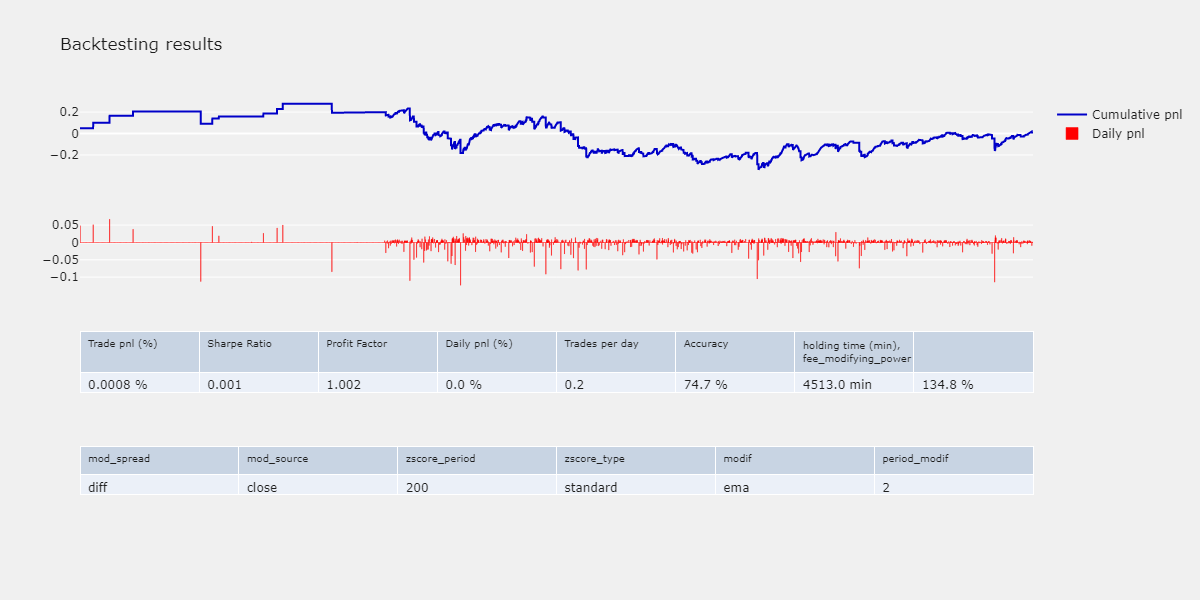

In [137]:
# backtest
df_trades, df_dailyTrades, metrics = standard_backtest(config, df=df, output='dfMetrics')

# plot all
fig = plot_standard_backtest_result(df_dailyTrades, metrics, config_signal)
fig.show('png', width=1200, height=600)

# In/out sample backtest - static

## Optimisation
function metric to maximize, function that takes list of backtest result metrics, and return the parameters of the best backtest (according to its metrics)

In [138]:
def get_best_configs(list_results, mod=0): # list result is a list of dic {'params':{}, 'metrics':{}}
    best_adjusted_metric = -1000
    best_params = {}
    for result in list_results:
        metrics = result['metrics']
        if result != {} and get_adjusted_metric(metrics, mod) > best_adjusted_metric and metrics['sharpe_ratio']>0 and metrics['trades_per_day']>2 and metrics['daily_pnl']>0.0005:
            best_adjusted_metric = get_adjusted_metric(metrics, mod)
            best_params = {
                'signal':result['signal'],
                'backtest': result['backtest']
            }
    if best_params != {}:
        return best_params
    else:
        best_adjusted_metric = -1000
        best_params = {}
        for result in list_results:
            metrics = result['metrics']
            if result != {} and get_adjusted_metric(metrics, mod) > best_adjusted_metric and metrics['daily_pnl']>0.0005:
                best_adjusted_metric = get_adjusted_metric(metrics, mod)
                best_params = {
                    'signal':result['signal'],
                    'backtest': result['backtest']
                }
        if best_params != {}:
            return best_params
        else:
            best_adjusted_metric = -1000
            best_params = {}
            for result in list_results:
                metrics = result['metrics']
                if result != {} and get_adjusted_metric(metrics, mod) > best_adjusted_metric:
                    best_adjusted_metric = get_adjusted_metric(metrics, mod)
                    best_params = {
                        'signal':result['signal'],
                        'backtest': result['backtest']
                    }
            if best_params != {}:
                return best_params
            else:
                return {}
            
def get_adjusted_metric(metrics, mod=0):
    if mod==0:
        return abs(metrics['sharpe_ratio']) * metrics['profit_factor'] * metrics['trade_pnl'] * metrics['trades_per_day']**1
    
    

## Generate list of configs

In [139]:
'''Must be changed for each strategy as it depends on the parameters with the config_signal used to build indicator'''

def get_list_configs_signal(config_signal_opt):
    list_configs = []
    for mod_spread in config_signal_opt['mod_spread']:
        for mod_source in config_signal_opt['mod_source']:
            for zscore_period in config_signal_opt['zscore_period']:
                for zscore_type in config_signal_opt['zscore_type']:
                    for modif in config_signal_opt['modif']:
                        if modif == '':
                            list_period_modif = [0]
                        else:
                            list_period_modif = config_signal_opt['period_modif']
                        for period_modif in list_period_modif:
                            config_to_add = {
                                'mod_spread' : mod_spread, # diff /return_0
                                'mod_source' : mod_source, # close / hl2
                                'zscore_period' : zscore_period,
                                'zscore_type' : zscore_type, # standard / ema
                                'modif' : modif, # '', 'ema', 'trima-sma'
                                'period_modif' : period_modif                                
                            }
                            list_configs.append(config_to_add)
    return list_configs

def get_list_configs_backtest(config_backtest_opt):
    # in this fnction we advise the length for all parameters to be equal among all trade id. i.e , if 'limit' is [0,1] for id 0, then 'limit' must be a 2-element list for all other trade id
    list_configs = []
    dic_list_limit = {id_trade:config_backtest_opt['id_trade'][id_trade]['limit'] for id_trade in config_backtest_opt['id_trade'].keys()}
    dic_list_sl = {id_trade:config_backtest_opt['id_trade'][id_trade]['sl'] for id_trade in config_backtest_opt['id_trade'].keys()}
    dic_list_tp = {id_trade:config_backtest_opt['id_trade'][id_trade]['tp'] for id_trade in config_backtest_opt['id_trade'].keys()}
    dic_list_entry_type = {id_trade:config_backtest_opt['id_trade'][id_trade]['entry_type'] for id_trade in config_backtest_opt['id_trade'].keys()}
    dic_list_exit_type = {id_trade:config_backtest_opt['id_trade'][id_trade]['exit_type'] for id_trade in config_backtest_opt['id_trade'].keys()}
    
    for index_limit in range(len(dic_list_limit[0])):
        for index_sl in range(len(dic_list_sl[0])):
            for index_tp in range(len(dic_list_tp[0])):
                for index_entry_type in range(len(dic_list_entry_type[0])):
                    for index_exit_type in range(len(dic_list_exit_type[0])):
                        config_backtest = {}
                        for id_trade in config_backtest_opt['id_trade'].keys():
                            config_backtest[id_trade] = {
                                'limit':dic_list_limit[id_trade][index_limit], # if limit=0 then it means there is no limit
                                'sl': dic_list_sl[id_trade][index_sl],
                                'sl_fee': config_backtest_opt['fees']['sl'],
                                'tp': dic_list_tp[id_trade][index_tp],
                                'tp_fee': config_backtest_opt['fees']['tp'],
                                'entry_type': dic_list_entry_type[id_trade][index_entry_type], # can be market or limit
                                'entry_fee': config_backtest_opt['fees'][dic_list_entry_type[id_trade][index_entry_type]],
                                'exit_type': dic_list_exit_type[id_trade][index_exit_type], # can be market or limit
                                'exit_fee': config_backtest_opt['fees'][dic_list_exit_type[id_trade][index_exit_type]]
                            }
                        
                    list_configs.append(config_backtest)
    return list_configs

## All in 1 function

In [140]:
def get_best_barams_inout_satic_standard(config, df=None, mod=0):
    config_df = config['df']
    config_signal_opt = config['signal_opt']
    config_backtest_opt = config['backtest_opt']
    
    log('In/Out sample static backtest of {}-{} {}'.format(config_df['s2'],config_df['s1'], config_df['timeframe_str']))
    
    if df is None:
        df = import_data(config_df)
        log('Data have been imported')
    
    index_thr_train_test = int(config_df['prop_test']*len(df))
    df_train = df.iloc[:index_thr_train_test]
    df_test = df.iloc[index_thr_train_test:-1].reset_index(drop=True)
    log('Data splitted with {}% test data'.format(100*config_df['prop_test']))
    
    # create list config on train
    list_configs_signal = get_list_configs_signal(config_signal_opt)
    list_configs_backtest = get_list_configs_backtest(config_backtest_opt)
    nbs_simu = len(list_configs_signal) * len(list_configs_backtest)
    log('{} configs have been created'.format(nbs_simu))
    
    # loop on configs for train
    list_results = []
    index_simu = 0
    for config_signal in list_configs_signal:
        for config_backtest in list_configs_backtest:
            # add indicator
            df_train = add_indicator_to_df(df_train, config_signal)        
            # run backtest
            first_index = get_first_index(config_signal)
            list_trades = backtest(df_train, config_backtest, first_index)    
            # extract df
            df_trades, df_dailyTrades = list_trades_to_df(list_trades)
            # show metrics
            metrics = get_trades_metrics(df_trades, df_dailyTrades)
            # create the result dictionnary
            result = {}
            result['df'] = {}
            result['df'] = config_df.copy()
            result['metrics'] = metrics.copy()
            result['signal'] = config_signal.copy()
            result['backtest'] = config_backtest.copy()
            # append result
            list_results.append(result)
            # compteur
            index_simu += 1
            if index_simu > nbs_simu/2 and index_simu-1 < nbs_simu/2:
                log('50% of simulations done')
        
    
    log('All {} simultaions have been completed'.format(nbs_simu))
    
    return list_results, df_test
        

    

## Parameters
length of in sample and out sample, 

In [141]:
'''Set of configs to change depending on the strategy'''

config_df = {
    "s1": "USDCHF",
    "s2": "EURCAD",
    "timeframe_str": "30min",
    "data_id": "forex_ohlc_2",
    "year_start": 2000,
    "year_end": 2020,
    "prop_test": 0.3
}

config_signal_opt = {
    'mod_spread' : ['diff'], # diff /return_0
    'mod_source' : ['close','hl2'], # close / hl2
    'zscore_period' : [5,8],
    'zscore_type' : ['standard'], # standard / ema
    'modif' : ['','ema'], # '', 'ema', 'trima-sma'
    'period_modif' : [5,8]
}

config_backtest_opt = {
    'id_trade': {
        0 : {
        'limit':[1], # if limit=0 then it means there is no limit
        'sl': [0],
        'tp': [0],
        'entry_type': ['market'], # can be market or limit
        'exit_type': ['market'], # can be market or limit
        }
    },
    'fees':{
        'limit':0,
        'market':0,
        'sl':0,
        'tp':0        
    }
    
}

config = {
    'df': config_df,
    'signal_opt': config_signal_opt,
    'backtest_opt': config_backtest_opt,
}

## Test of 1 in/out sample backtest

In [142]:
list_results, df_test = get_best_barams_inout_satic_standard(config, df=None, mod=0)
    
# extract best params
best_params = get_best_configs(list_results, 0)

log('Best params extracted, now running backtest on test sample')
# add indicator
df_test = add_indicator_to_df(df_test, best_params['signal'])        
# run backtest
first_index = get_first_index(config_signal)
list_trades = backtest(df_test, best_params['backtest'], first_index)    
# extract df
df_trades, df_dailyTrades = list_trades_to_df(list_trades)
# show metrics
metrics = get_trades_metrics(df_trades, df_dailyTrades)

[2021-01-20 13:17:35.992896] - In/Out sample static backtest of EURCAD-USDCHF 30min
[2021-01-20 13:17:53.430696] - Data have been imported
[2021-01-20 13:17:53.444660] - Data splitted with 30.0% test data
[2021-01-20 13:17:53.444660] - 12 configs have been created
[2021-01-20 13:18:11.412107] - All 12 simultaions have been completed
[2021-01-20 13:18:11.430031] - Best params extracted, now running backtest on test sample


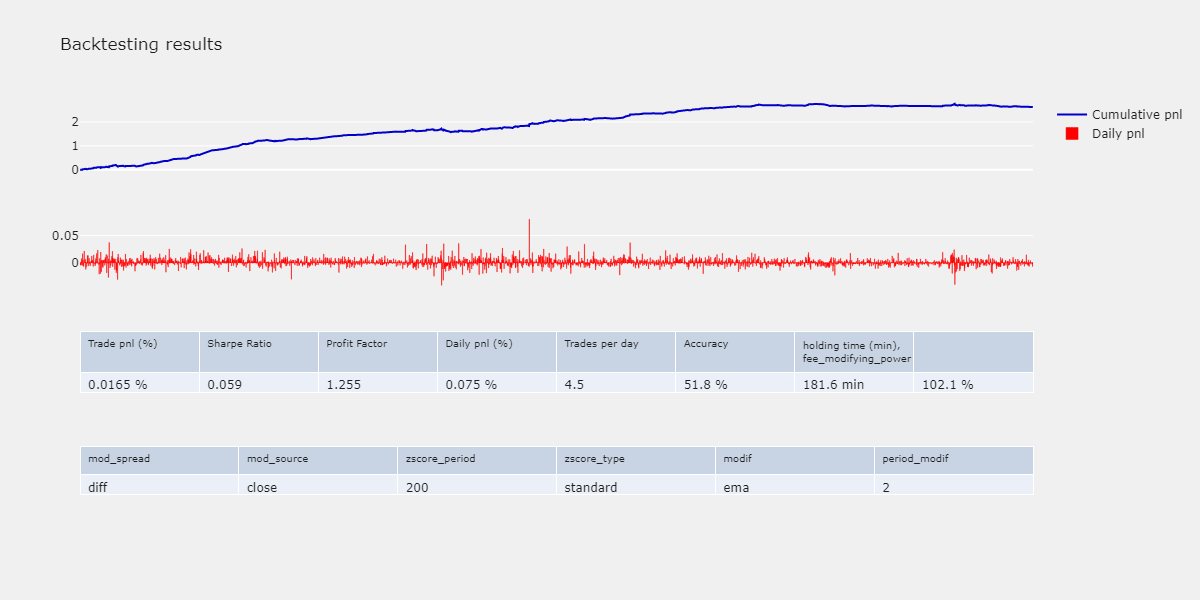

In [144]:
fig = plot_standard_backtest_result(df_dailyTrades, metrics, config_signal)
fig.show('png', width=1200, height=600)

## Multi processing
1 core = 1 backtest in sample

### Generate workers input
given the list of allowed parameters, return a list of configs dictionnaries

In [145]:
def get_list_worker_input(config, df=None):
    config_df = config['df']
    config_signal_opt = config['signal_opt']
    config_backtest_opt = config['backtest_opt']
    
    log('In/Out sample static backtest of {}-{} {}'.format(config_df['s2'],config_df['s1'], config_df['timeframe_str']))
    
    if df is None:
        df = import_data(config_df)
        log('Data have been imported')
    
    index_thr_train_test = int(config_df['prop_test']*len(df))
    
    df_train = df.iloc[:index_thr_train_test]
    df_test = df.iloc[index_thr_train_test:-1].reset_index(drop=True)
    
    log('Data splitted with {}% test data'.format(100*config_df['prop_test']))
    
    # create list config on train
    list_configs_signal = get_list_configs_signal(config_signal_opt)
    list_configs_backtest = get_list_configs_backtest(config_backtest_opt)
    
    list_worker_input = []
    index_simu = 0
    for config_signal in list_configs_signal:
        for config_backtest in list_configs_backtest:
            dic_worker_input = {
                'backtest':config_backtest,
                'signal':config_signal,
                'df_train':df_train,
                'df':config_df
            }
            list_worker_input.append(dic_worker_input.copy())
            del dic_worker_input
            
    return list_worker_input, df_test

### Worker
define the worker function worker(config) => dictionnary of result (metrics)

In [146]:
'''in multi_processing_get_best_params modify the functions needed in section add_indicator'''

def worker_static(worker_input):
    config_backtest = worker_input['backtest']
    config_signal = worker_input['signal']
    df_train = worker_input['df_train']
    config_df = worker_input['df']

    df_train = add_indicator_to_df(df_train, config_signal)        
    # run backtest
    first_index = get_first_index(config_signal)
    list_trades = backtest(df_train, config_backtest, first_index)    
    # extract df
    df_trades, df_dailyTrades = list_trades_to_df(list_trades)
    # show metrics
    metrics = get_trades_metrics(df_trades, df_dailyTrades)
    # create the result dictionnary
    result = {}
    result['df'] = {}
    result['df'] = config_df.copy()
    result['metrics'] = metrics.copy()
    result['signal'] = config_signal.copy()
    result['backtest'] = config_backtest.copy()

    return result

def multi_processing_get_best_params(config):    
    
    if __name__ ==  '__main__': 
        # put necessary functions inside worker.py
        import inspect
        with open('worker.py', 'w') as f:
            f.write('')
            f.close()
        with open('worker.py', 'r+') as f:
            f.write('import numpy as np, pandas as pd, tulipy as ti, time, json, datetime, os, tulipy as ti\n')
            # add indicator
            f.write(inspect.getsource(get_zscore))
            f.write(inspect.getsource(standard_zscoring))
            f.write(inspect.getsource(ema_zscoring))
            f.write(inspect.getsource(add_indicator_to_df))
            f.write(inspect.getsource(get_first_index))
            # signals
            f.write(inspect.getsource(get_condition_to_long_exit))
            f.write(inspect.getsource(get_condition_to_short_exit))
            f.write(inspect.getsource(get_condition_to_long_entry))
            f.write(inspect.getsource(get_condition_to_short_entry))
            # backtest
            f.write(inspect.getsource(backtest))
            f.write(inspect.getsource(get_dic_entry_to_add))
            f.write(inspect.getsource(get_sl_price))
            f.write(inspect.getsource(get_tp_price))
            f.write(inspect.getsource(get_daily_fastTrades_df))
            f.write(inspect.getsource(list_trades_to_df))
            # metrics
            f.write(inspect.getsource(get_trades_metrics))
            # worker static
            f.write(inspect.getsource(worker_static))

            f.close()
            
        import worker 
        
        log('Building list of configs and importing data')
        list_worker_input, df_test = get_list_worker_input(config)
        nbs_simu = len(list_worker_input)

        # start multi pro
        num_processors = mp.cpu_count()  - 1
        log('Starting multi pro of {} backtesting with {} processors'.format(nbs_simu, num_processors))
        p = Pool(processes = num_processors)
        list_results = p.map(worker.worker_static,list_worker_input)
        # saving output
        p.close()

        log('All {} simultaions have been completed'.format(nbs_simu))

        return list_results, df_test

### Test multi processing for 1 symbol
give a symbol, the list of allowed parameters and run multi processing to get the list of all backtest results. Then pick the best result and backtest the out sample with its parameters

#### parameters

In [149]:
'''Set of configs to change depending on the strategy'''

config_df = {
    "s1": "USDCHF",
    "s2": "EURCAD",
    "timeframe_str": "30min",
    "data_id": "forex_ohlc_2",
    "year_start": 2000,
    "year_end": 2020,
    "prop_test": 0.3
}

config_signal_opt = {
    'mod_spread' : ['diff'], # diff /return_0
    'mod_source' : ['close','hl2'], # close / hl2
    'zscore_period' : [5,8,13,21,34,55,89,144,233,377,610,987],
    'zscore_type' : ['standard','ema'], # standard / ema
    'modif' : ['','ema','trima_sma'], # '', 'ema', 'trima-sma'
    'period_modif' : [5,8,13,21,89]
}

config_backtest_opt = {
    'id_trade': {
        0 : {
        'limit':[1], # if limit=0 then it means there is no limit
        'sl': [0],
        'tp': [0],
        'entry_type': ['market'], # can be market or limit
        'exit_type': ['market'], # can be market or limit
        }
    },
    'fees':{
        'limit':0,
        'market':0,
        'sl':0,
        'tp':0        
    }
    
}

config = {
    'df': config_df,
    'signal_opt': config_signal_opt,
    'backtest_opt': config_backtest_opt,
}

#### run code

[2021-01-20 13:35:03.271665] - Building list of configs and importing data
[2021-01-20 13:35:03.271665] - In/Out sample static backtest of EURCAD-USDCHF 30min
[2021-01-20 13:35:19.469718] - Data have been imported
[2021-01-20 13:35:19.482656] - Data splitted with 30.0% test data
[2021-01-20 13:35:19.482656] - Starting multi pro of 528 backtesting with 7 processors
[2021-01-20 13:36:26.695487] - All 528 simultaions have been completed
[2021-01-20 13:36:26.730560] - Best params extracted, now running backtest on test sample


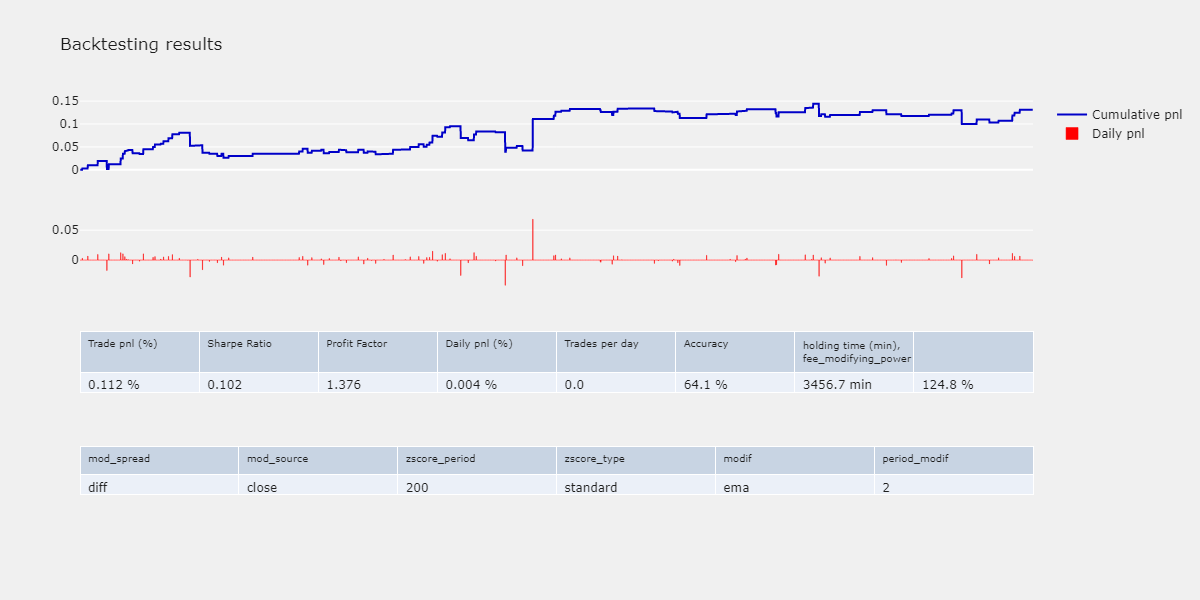

In [150]:
list_results, df_test = multi_processing_get_best_params(config)
# extract best params
best_params = get_best_configs(list_results, mod=0)
log('Best params extracted, now running backtest on test sample')
# add indicator
if best_params != {}:
    df_test = add_indicator_to_df(df_test, best_params['signal'])        
    # run backtest
    first_index = get_first_index(config_signal)
    list_trades = backtest(df_test, best_params['backtest'], first_index)
    # extract df
    df_trades, df_dailyTrades = list_trades_to_df(list_trades)
    # show metrics
    metrics = get_trades_metrics(df_trades, df_dailyTrades)

    fig = plot_standard_backtest_result(df_dailyTrades, metrics, config_signal)
    fig.show('png', width=1200, height=600)  

### Multi processing on a group of symbol
Loop on all the necessary symbols, and in/out static backtest with multi processing

In [167]:
list(asset_type.get_df(asset_type.TYPE_Forex).head(5).index)

['USDCNH', 'USDNOK', 'USDSEK', 'GBPAUD', 'USDMXN']

[2021-01-20 17:09:22.030449] - In/Out sample static backtest of USDCAD-GBPUSD
[2021-01-20 17:09:22.044412] - Building list of configs and importing data
[2021-01-20 17:09:22.045409] - In/Out sample static backtest of USDCAD-GBPUSD 30min
[2021-01-20 17:09:41.715168] - Data have been imported
[2021-01-20 17:09:41.735118] - Data splitted with 30.0% test data
[2021-01-20 17:09:41.735118] - Starting multi pro of 252 backtesting with 7 processors
[2021-01-20 17:10:31.968545] - All 252 simultaions have been completed
[2021-01-20 17:10:32.017414] - Best params extracted, now running backtest on test sample
[2021-01-20 17:10:36.170340] - In/Out sample static backtest of EURUSD-GBPUSD
[2021-01-20 17:10:36.185299] - Building list of configs and importing data
[2021-01-20 17:10:36.186290] - In/Out sample static backtest of EURUSD-GBPUSD 30min
[2021-01-20 17:10:56.084548] - Data have been imported
[2021-01-20 17:10:56.105493] - Data splitted with 30.0% test data
[2021-01-20 17:10:56.105493] - Start

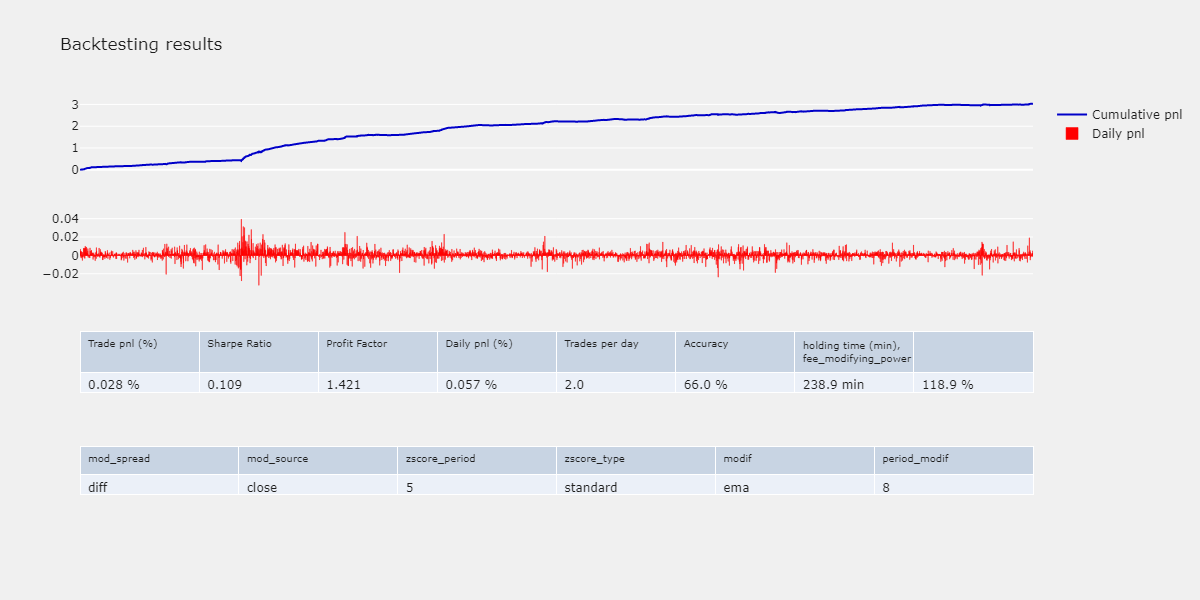

[2021-01-20 17:13:08.211912] - In/Out sample static backtest of NZDUSD-GBPUSD
[2021-01-20 17:13:08.226874] - Building list of configs and importing data
[2021-01-20 17:13:08.226874] - In/Out sample static backtest of NZDUSD-GBPUSD 30min
[2021-01-20 17:13:27.952835] - Data have been imported
[2021-01-20 17:13:27.972782] - Data splitted with 30.0% test data
[2021-01-20 17:13:27.972782] - Starting multi pro of 252 backtesting with 7 processors
[2021-01-20 17:14:20.019629] - All 252 simultaions have been completed
[2021-01-20 17:14:20.059545] - Best params extracted, now running backtest on test sample
[2021-01-20 17:14:25.144926] - In/Out sample static backtest of EURUSD-USDCAD
[2021-01-20 17:14:25.158889] - Building list of configs and importing data
[2021-01-20 17:14:25.158889] - In/Out sample static backtest of EURUSD-USDCAD 30min
[2021-01-20 17:14:44.653045] - Data have been imported
[2021-01-20 17:14:44.673015] - Data splitted with 30.0% test data
[2021-01-20 17:14:44.673015] - Start

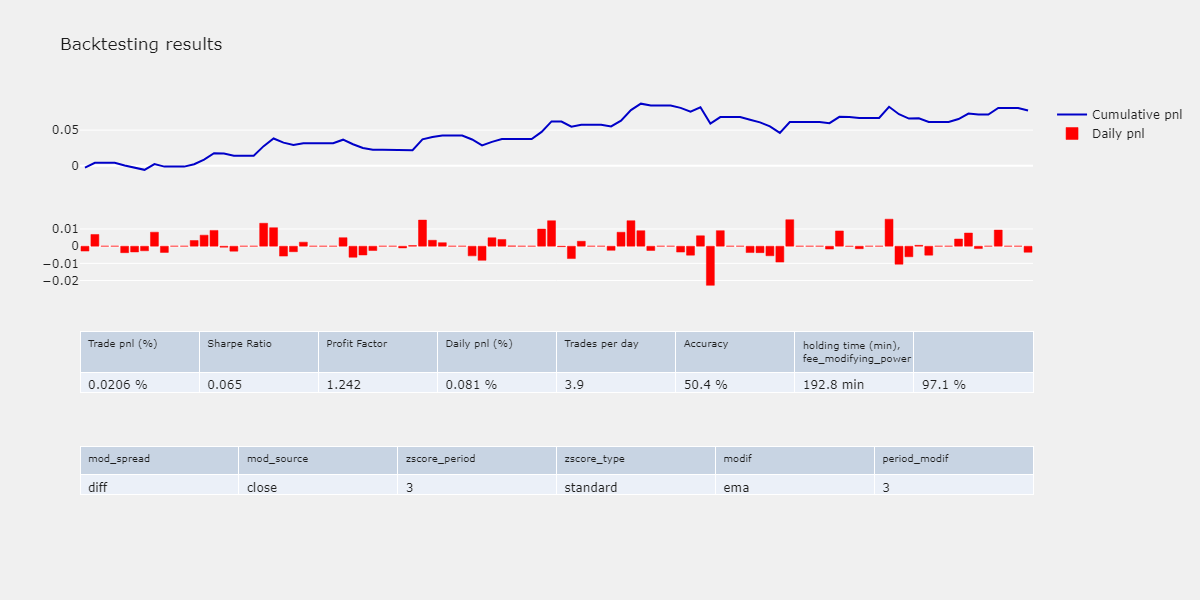

[2021-01-20 17:17:06.989849] - In/Out sample static backtest of NZDUSD-USDCAD
[2021-01-20 17:17:07.004809] - Building list of configs and importing data
[2021-01-20 17:17:07.004809] - In/Out sample static backtest of NZDUSD-USDCAD 30min
[2021-01-20 17:17:25.551498] - Data have been imported
[2021-01-20 17:17:25.571444] - Data splitted with 30.0% test data
[2021-01-20 17:17:25.571444] - Starting multi pro of 252 backtesting with 7 processors
[2021-01-20 17:18:22.587214] - All 252 simultaions have been completed
[2021-01-20 17:18:22.633091] - Best params extracted, now running backtest on test sample
[2021-01-20 17:18:26.625417] - In/Out sample static backtest of AUDUSD-EURUSD
[2021-01-20 17:18:26.640378] - Building list of configs and importing data
[2021-01-20 17:18:26.640378] - In/Out sample static backtest of AUDUSD-EURUSD 30min
[2021-01-20 17:18:45.374927] - Data have been imported
[2021-01-20 17:18:45.394875] - Data splitted with 30.0% test data
[2021-01-20 17:18:45.394875] - Start

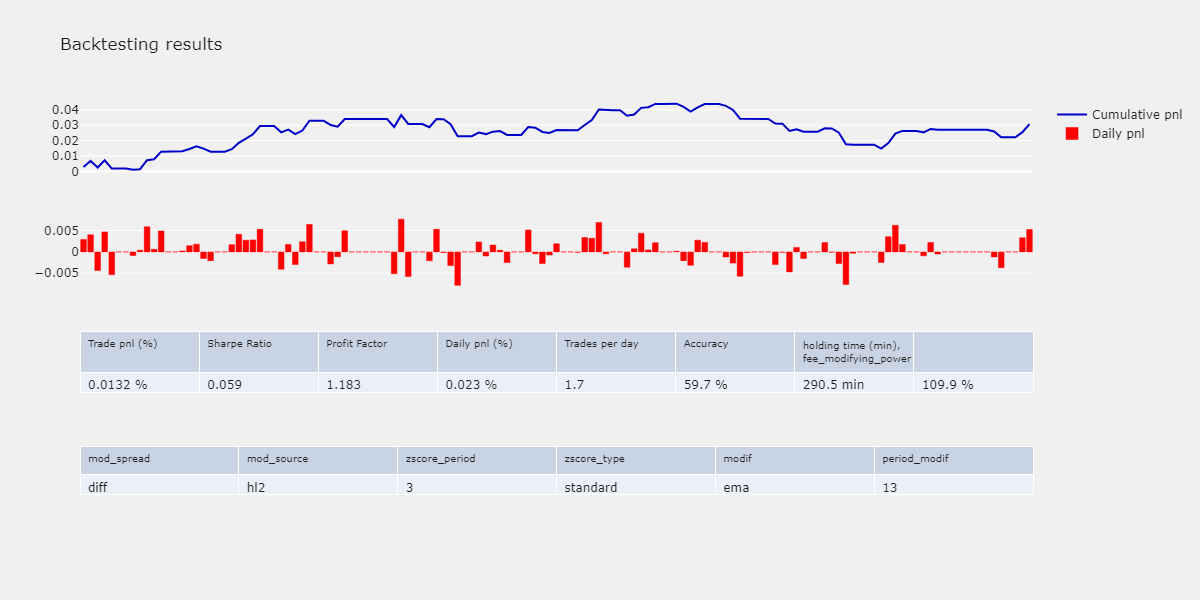

[2021-01-20 17:19:46.269152] - In/Out sample static backtest of NZDUSD-EURUSD
[2021-01-20 17:19:46.283111] - Building list of configs and importing data
[2021-01-20 17:19:46.283111] - In/Out sample static backtest of NZDUSD-EURUSD 30min
[2021-01-20 17:20:05.764790] - Data have been imported
[2021-01-20 17:20:05.785763] - Data splitted with 30.0% test data
[2021-01-20 17:20:05.785763] - Starting multi pro of 252 backtesting with 7 processors
[2021-01-20 17:21:02.030362] - All 252 simultaions have been completed
[2021-01-20 17:21:02.084217] - Best params extracted, now running backtest on test sample
[2021-01-20 17:21:07.207987] - In/Out sample static backtest of NZDUSD-AUDUSD
[2021-01-20 17:21:07.221949] - Building list of configs and importing data
[2021-01-20 17:21:07.221949] - In/Out sample static backtest of NZDUSD-AUDUSD 30min
[2021-01-20 17:21:27.062444] - Data have been imported
[2021-01-20 17:21:27.082391] - Data splitted with 30.0% test data
[2021-01-20 17:21:27.083389] - Start

In [180]:
dic_all_symbol = json.load(open('configs/c_allSymbol.json','r'))
list_symbols = list(asset_type.get_df(asset_type.TYPE_ForexMajor).head(5).index)
list_pair_computed = []
for s1 in list_symbols:
    for s2 in list_symbols:
        if (s1, s2) not in list_pair_computed and s1 != s2 and (s2, s1) not in list_pair_computed:
            log('In/Out sample static backtest of {}-{}'.format(s2,s1))
            
            
            '''Set of configs to change depending on the strategy'''

            config_df = {
                "s1": s1,
                "s2": s2,
                "timeframe_str": "30min",
                "data_id": "forex_ohlc_2",
                "year_start": 2000,
                "year_end": 2020,
                "prop_test": 0.3
            }

            config_signal_opt = {
                'mod_spread' : ['diff'], # diff /return_0
                'mod_source' : ['close','hl2'], # close / hl2
                'zscore_period' : [3,5,8,13,21,34,55],
                'zscore_type' : ['standard','ema'], # standard / ema
                'modif' : ['','ema','trima_sma'], # '', 'ema', 'trima-sma'
                'period_modif' : [3,5,8,13]
            }

            config_backtest_opt = {
                'id_trade': {
                    0 : {
                    'limit':[1], # if limit=0 then it means there is no limit
                    'sl': [0],
                    'tp': [0],
                    'entry_type': ['market'], # can be market or limit
                    'exit_type': ['market'], # can be market or limit
                    }
                },
                'fees':{
                    'limit':0,
                    'market':0,
                    'sl':0,
                    'tp':0        
                }

            }

            config = {
                'df': config_df,
                'signal_opt': config_signal_opt,
                'backtest_opt': config_backtest_opt,
            }
            
            list_results, df_test = multi_processing_get_best_params(config)
            # extract best params
            best_params = get_best_configs(list_results, mod=0)
            log('Best params extracted, now running backtest on test sample')
            # add indicator
            if best_params != {}:
                df_test = add_indicator_to_df(df_test, best_params['signal'])        
                # run backtest
                first_index = get_first_index(config_signal)
                list_trades = backtest(df_test, best_params['backtest'], first_index)
                # extract df
                df_trades, df_dailyTrades = list_trades_to_df(list_trades)
                # show metrics
                metrics = get_trades_metrics(df_trades, df_dailyTrades)
                
                if metrics['sharpe_ratio'] > 0.03:
                    
                    fig = plot_standard_backtest_result(df_dailyTrades, metrics, best_params['signal'])
                    fig.show('png', width=1200, height=600)  
            
            
            
            
            
            
            list_pair_computed.append((s1,s2))
print('{} pairs foud'.format(len(list_pair_computed)))

# In/out sample backtest - dynamic

## Parameters
length of in sample and out sample, 

## Optimisation
function metric to maximize, function that takes list of backtest result metrics, and return the parameters of the best backtest (according to its metrics)

## Test of 1 in/out sample backtest

## Multi processing
1 core = 1 backtest in sample

### Generate configs
given the list of allowed parameters, return a list of configs dictionnaries

### Worker
define the worker function worker(config) => dictionnary of result (metrics)

### Test multi processing for 1 symbol
give a symbol, the list of allowed parameters and run multi processing to get the list of all backtest results. Then pick the best result and backtest the out sample with its parameters